# Regresión logística binaria: estimación MAP

La regularización $\ell_2$ de regresión logística binaria consiste en asumir un prior Gaussiano para $\boldsymbol{w}$,
$$p(\boldsymbol{w})=\mathcal{N}(\boldsymbol{w}\mid\boldsymbol{0},\lambda^{-1}\mathbf{I})$$
y minimizar la log-verosimilitud negativa penalizada para hallar un estimador MAP de $\boldsymbol{w}$,
$$\begin{align*}
\boldsymbol{w}_{\text{map}}%
&=\operatorname*{argmax}_{\boldsymbol{w}}\;p(\boldsymbol{w}\mid\mathcal{D})\\%
&=\operatorname*{argmax}_{\boldsymbol{w}}\;\log p(\mathcal{D}\mid\boldsymbol{w})+\log p(\boldsymbol{w})\\%
&=\operatorname*{argmax}_{\boldsymbol{w}}\;\operatorname{LL}(\boldsymbol{w})-\lambda\boldsymbol{w}^t\boldsymbol{w}\\%
&=\operatorname*{argmin}_{\boldsymbol{w}}\;\operatorname{PNLL}(\boldsymbol{w})%
\qquad\text{con}\qquad%
\operatorname{PNLL}(\boldsymbol{w})=\operatorname{NLL}(\boldsymbol{w})+\lambda\boldsymbol{w}^t\boldsymbol{w}\\%
\end{align*}$$

**Ejemplo:** datos sintéticos 2d y modelo polinómico

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Ntrain, Ntest, n_clusters_per_class, class_sep = 100, 1000, 2, 0.1 # Ntrain = 50 en PML1
N = Ntrain + Ntest
X, y = make_classification(n_samples=N, n_features=2, n_redundant=0, n_classes=2, 
    n_clusters_per_class=n_clusters_per_class, class_sep=class_sep, random_state=1)
Xtrain = X[:Ntrain, :]; ytrain = y[:Ntrain]
Xtest = X[Ntrain:, :]; ytest = y[Ntrain:]
print(np.c_[Xtrain[:min(Ntrain, 10), :], ytrain[:min(Ntrain, 10)]])

[[-6.48928917e-01  1.96408596e-03  0.00000000e+00]
 [-2.69137092e-01 -6.04600245e-01  1.00000000e+00]
 [ 8.06035976e-01 -7.45521952e-01  0.00000000e+00]
 [-8.22767535e-01  1.71948873e-01  0.00000000e+00]
 [-4.75851630e-01  4.79774731e-01  0.00000000e+00]
 [ 9.17638363e-01  1.03699227e+00  1.00000000e+00]
 [ 4.80934984e-01  3.09073076e-01  1.00000000e+00]
 [ 7.12475381e-01  7.10609599e-01  1.00000000e+00]
 [-1.01316079e+00  8.37223758e-04  1.00000000e+00]
 [ 1.70220224e+00  7.64383740e-01  1.00000000e+00]]


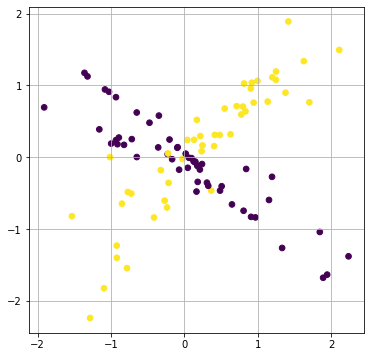

In [2]:
fig, ax = plt.subplots(figsize=(6, 6)); ax.grid(); ax.scatter(*Xtrain.T, c=ytrain, s=32)
x_min, x_max = ax.get_xlim(); y_min, y_max = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
XX = np.c_[np.ravel(xx), np.ravel(yy)]

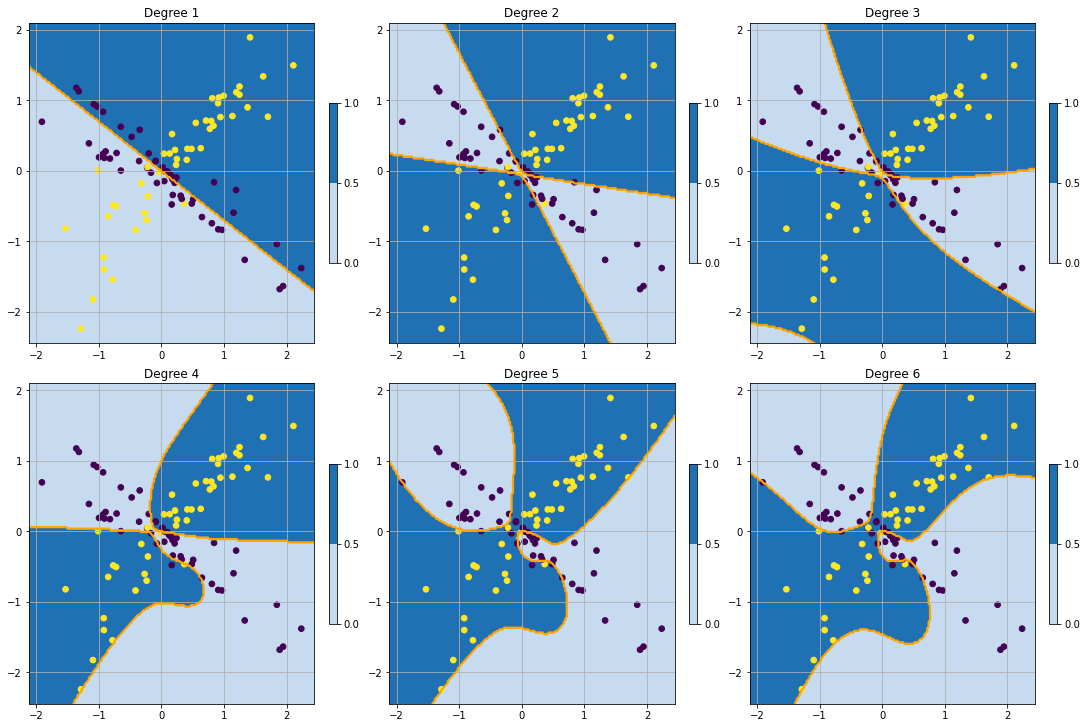

In [3]:
degrees = [1, 2, 3, 4, 5, 6]; nrows, ncols = 2, 3
acc_train = np.zeros(len(degrees)); acc_test = np.zeros(len(degrees)) 
C=1e4 # C = 1 / lambda: varianza del prior
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10), constrained_layout=True)
for i, degree in enumerate(degrees):
    ax = axes.flat[i]; ax.axis('off'); ax = fig.add_subplot(nrows, ncols, i + 1); ax.grid()
    transformer = PolynomialFeatures(degree)
    Xtrain_poly = transformer.fit_transform(Xtrain)[:, 1:] # skip the first column of 1s
    model = LogisticRegression(C=C, max_iter=1000)
    model = model.fit(Xtrain_poly, ytrain)
    acc_train[i] = accuracy_score(ytrain, model.predict(Xtrain_poly))
    Xtest_poly = transformer.fit_transform(Xtest)[:, 1:] # skip the first column of 1s
    acc_test[i] = accuracy_score(ytest, model.predict(Xtest_poly))
    XX_poly = transformer.fit_transform(XX)[:, 1:] # skip the first column of 1s
    z = lambda x: model.coef_[0] @ x
    zz = np.heaviside(np.apply_along_axis(z, 1, XX_poly), 0.0)
    ax.contour(xx, yy, zz.reshape(xx.shape), 1, colors='orange', linestyles='solid')
    cp = ax.contourf(xx, yy, zz.reshape(xx.shape), 1, cmap='Blues')
    plt.colorbar(cp, ax=ax, shrink=0.5)
    ax.scatter(*Xtrain.T, c=ytrain, s=32)
    ax.set_title('Degree {}'.format(degree))

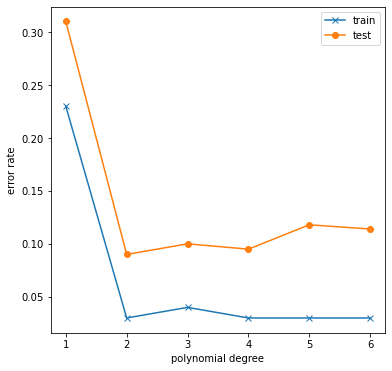

In [4]:
plt.figure(figsize=(6, 6))
plt.plot(degrees, 1.0 - acc_train, 'x-', label='train')
plt.plot(degrees, 1.0 - acc_test, 'o-', label='test')
plt.legend()
plt.xlabel('polynomial degree')
plt.ylabel('error rate');

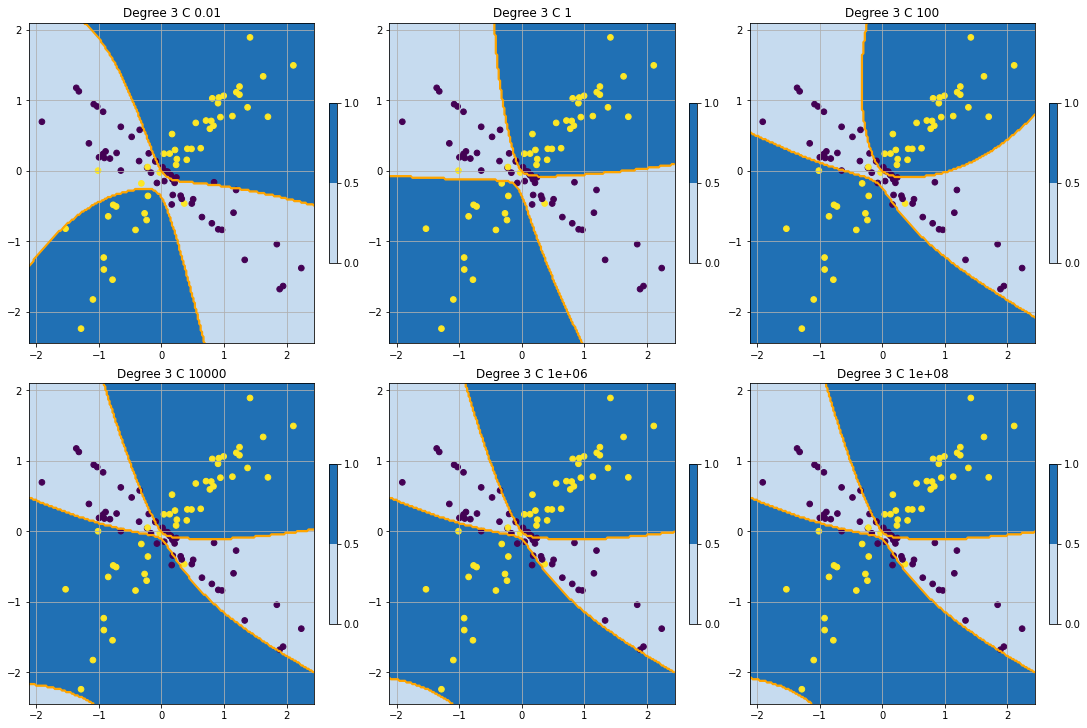

In [5]:
degree = 3; Cs = [1e-2, 1e0, 1e2, 1e4, 1e6, 1e8]; nrows, ncols = 2, 3
acc_train = np.zeros(len(Cs)); acc_test = np.zeros(len(Cs)) 
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10), constrained_layout=True)
for i, C in enumerate(Cs):
    ax = axes.flat[i]; ax.axis('off'); ax = fig.add_subplot(nrows, ncols, i + 1); ax.grid()
    transformer = PolynomialFeatures(degree)
    Xtrain_poly = transformer.fit_transform(Xtrain)[:, 1:] # skip the first column of 1s
    model = LogisticRegression(C=Cs[i], max_iter=1000)
    model = model.fit(Xtrain_poly, ytrain)
    acc_train[i] = accuracy_score(ytrain, model.predict(Xtrain_poly))
    Xtest_poly = transformer.fit_transform(Xtest)[:, 1:] # skip the first column of 1s
    acc_test[i] = accuracy_score(ytest, model.predict(Xtest_poly))
    XX_poly = transformer.fit_transform(XX)[:, 1:] # skip the first column of 1s
    z = lambda x: model.coef_[0] @ x
    zz = np.heaviside(np.apply_along_axis(z, 1, XX_poly), 0.0)
    ax.contour(xx, yy, zz.reshape(xx.shape), 1, colors='orange', linestyles='solid')
    cp = ax.contourf(xx, yy, zz.reshape(xx.shape), 1, cmap='Blues')
    plt.colorbar(cp, ax=ax, shrink=0.5)
    ax.scatter(*Xtrain.T, c=ytrain, s=32)
    ax.set_title('Degree {} C {:g}'.format(degree, Cs[i]))